In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
import tensorflow as tf

## Loading datasets

In [ ]:
train_data = pd.read_csv('train.csv')
train_data.head()

,text,Y
0,advice Talk neighbours family exchange phone n...,2
1,Coronavirus Australia: Woolworths give elderly...,2
2,"My food stock one empty... PLEASE, panic, THER...",2
3,"Me, ready go supermarket outbreak. Not I'm par...",0
4,As news regionÂs first confirmed COVID- case ...,2


## Preprocessing Phrase

TODO:
- Tokenize
- Lemmatize
- Remove non alphabet character

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_phrase(document):
    preprocessed_texts = []

    for text in document['text'].values:
        result = [token.lemma_ for token in nlp(text) if token.is_alpha]
        preprocessed_texts.append(" ".join(result))

    return preprocessed_texts
#     return document['Phrase'].values

In [ ]:
train_sent = preprocess_phrase(train_data)
print(len(train_sent))

41152


## Generate train and validation test

In [ ]:
from sklearn.model_selection import train_test_split
target = tf.keras.utils.to_categorical(train_data['Y'].values)

X_train, X_val, y_train, y_val = train_test_split(
    train_sent,
    target,
    test_size=0.2,
    stratify=target
)
print(len(X_train), len(X_val), len(y_train), len(y_val))

32921 8231 32921 8231


## Model Creation

In [ ]:
unique_words = set()
len_max = 0

for sent in X_train:
    tokens = sent.split()
    unique_words.update(tokens)

    if len_max < len(tokens):
        len_max = len(tokens)

print(len(unique_words), len_max)

31410 54


In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=len(unique_words),
    output_mode='int',
    output_sequence_length=len_max
)

vectorize_layer.adapt(list(unique_words))

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(len(unique_words), 300, input_length=len_max))
model.add(tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(target.shape[1],activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 54)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 54, 300)           9423000   
                                                                 
 lstm_2 (LSTM)               (None, 54, 128)           219648    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                      

## Fit Model

In [ ]:
# X_train = [" ".join(lst) for lst in X_train]
# X_val = [" ".join(lst) for lst in X_val]

X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_val = np.array(list(X_val))
y_val = np.array(y_val)
#hi i had a horse. He played games.His name was Manas.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

history = model.fit(
    np.array(X_train, dtype=object),
    np.array(y_train),
    validation_data=(
        np.array(X_val, dtype=object),
        np.array(y_val)
    ),
    epochs=5,
    batch_size=256,
    verbose=1,
    callbacks=callback
)

model.save("model")

Epoch 1/5
129/129 [==============================] - ETA: 0s - loss: 1.0361 - accuracy: 0.4462

129/129 [==============================] - 191s 1s/step - loss: 1.0361 - accuracy: 0.4462 - val_loss: 1.0363 - val_accuracy: 0.4445
Epoch 2/5
116/129 [=========================>....] - ETA: 18s - loss: 1.0343 - accuracy: 0.4468

KeyboardInterrupt: 

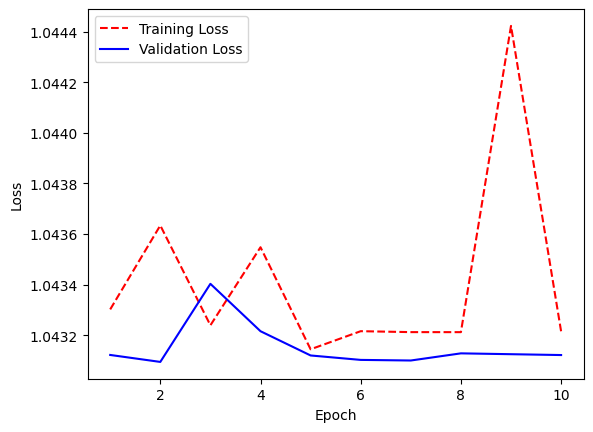

In [ ]:
import matplotlib.pyplot as plt

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [25]:
y_pred = model.predict(X_val)
classes_x = np.argmax(y_pred,axis=1)
classes_x[::10] = 0
classes_x[::20] = 1
classes_y = np.argmax(y_val,axis=1)

cm = confusion_matrix(classes_x,classes_y)
# test_data['Sentiment'] = classes_x
# test_data.to_csv('result.csv',index=False)

# result = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')
# result['Sentiment'] = classes_x
# result.to_csv('submit.csv',index=False)
# result

258/258 [==============================] - 17s 65ms/step


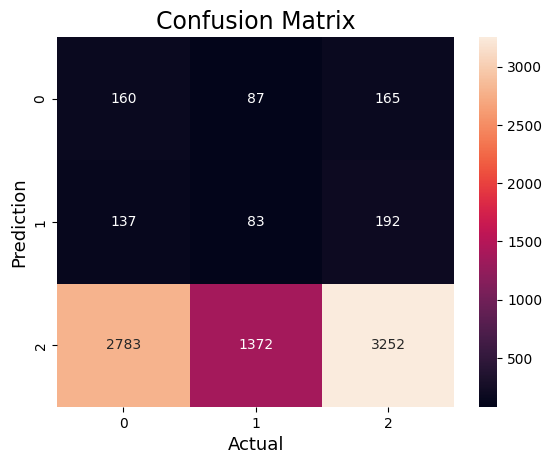

In [26]:
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [27]:
accuracy = accuracy_score(classes_x,classes_y)
print("Accuracy   :", accuracy)

Accuracy   : 0.4246142631515004
